### Positional Encoding

Let $ X \in \mathbb{R}^{l \times d} $ a sequence of $l$ vectors embeddings of dimension $d$.

$$ X = 

\begin{bmatrix}

    \vec{x}^1 \\
    \vec{x}^2 \\
    \vdots \\
    \vec{x}^l

\end{bmatrix}


= \begin{bmatrix}

    x^1_1 & x^1_2 & \cdots & x^1_d \\
    x^2_1 & x^2_2 & \cdots & x^2_d \\
    \vdots & \vdots & \ddots & \vdots \\
    x^l_1 & x^l_2 & \cdots & x^l_d

\end{bmatrix} $$


With $ \vec{x}^t \in \mathbb{R}^d $ the embedding vector of the word at position $t$ in the sequence. To inform the embedding vectors about their position, each one is added the vector $ \vec{p} ^ t $ that we will describe below.
 
$$ \vec{p}^t = \begin{bmatrix} p^t_1 & p^t_2 & \cdots p^t_d \end{bmatrix} $$ 

The attention is all you need paper, proposes a positional encoding function $ \text{P}: \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}^d $ as:

$$
\text{P}(t, s)  = 

\begin{cases} 
    \sin(\omega_k t) & \text{si } s = 2k \\
    \cos(\omega_k t) & \text{si } s = 2k + 1
\end{cases}
$$

With the "frequencies" defined by $$ \omega_k = \frac{1}{N ^ {2 k /d}} = \exp(-\frac{2k}{d}\log(N))$$

And a constant $N$.


The positional encoding matrix $ P \in \mathbb{R}^{l \times d} $ will be:

$$ P = \begin{bmatrix}

    0 & 1 & 0 & 1 & \cdots & 0 & 1 \\
    \sin(\omega_1) & \cos(\omega_1) & \sin(\omega_2) & \cos(\omega_2) & \cdots & \sin(\omega_{d/2}) & \cos(\omega_{d/2}) \\
    \sin(\omega_1 2) & \cos(\omega_1 2) & \sin(\omega_2 2) & \cos(\omega_2 2) & \cdots & \sin(\omega_{d/2} 2) & \cos(\omega_{d/2} 2) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    \sin(\omega_1 (l-1)) & \cos(\omega_1 (l-1)) & \sin(\omega_2 (l-1)) & \cos(\omega_2 (l-1)) & \cdots & \sin(\omega_{d/2} (l-1)) & \cos(\omega_{d/2} (l-1))
\end{bmatrix} $$

In this implementation, it is considered that the positional encoding matrix $ P $ is pre-computed only once and is added to the sequence of embeddings $ X $ at each step of the network.

$$ X := X + P $$


In [1]:
import torch
# For comparison with the pytorch's implementation
torch.set_float32_matmul_precision('highest')

In [2]:
import math
import torch
from torch import Tensor
from torch.nn import Module
from torch.nn import Parameter
from torch import exp, sin, cos

class PositionalEncoding(Module):
    def __init__(self, sequence_lenght_limit: int, model_dimension: int, scaling_factor: int = 10000, device=None, dtype=None):
        super().__init__()
        self.embeddings = Parameter(data=torch.zeros(sequence_lenght_limit, model_dimension, device=device, dtype=dtype), requires_grad=False)
        for dimension in range(model_dimension):
            self.embeddings[:,dimension] = dimension // 2 + 1
            self.embeddings[:,dimension] = exp(-2*self.embeddings[:,dimension] * math.log(scaling_factor) / model_dimension)
            for sequence in range(sequence_lenght_limit):
                if dimension % 2 == 0:
                    self.embeddings[sequence,dimension] = sin(sequence * self.embeddings[sequence,dimension])
                else:
                    self.embeddings[sequence,dimension] = cos(sequence * self.embeddings[sequence,dimension])

    def forward(self, input: Tensor) -> Tensor:
        input = input + self.embeddings[:,:input.size(1)]
        return input
    


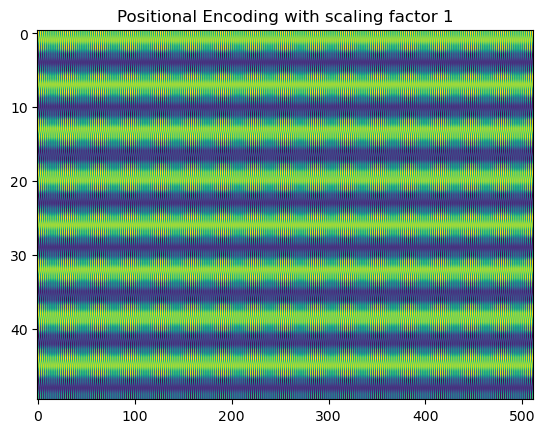

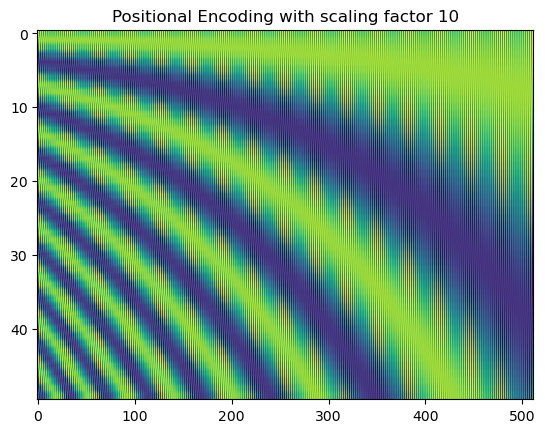

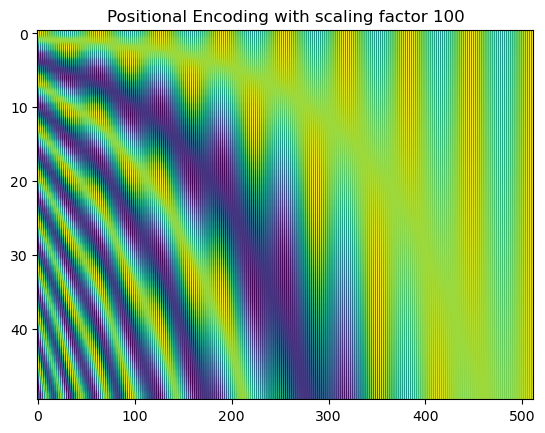

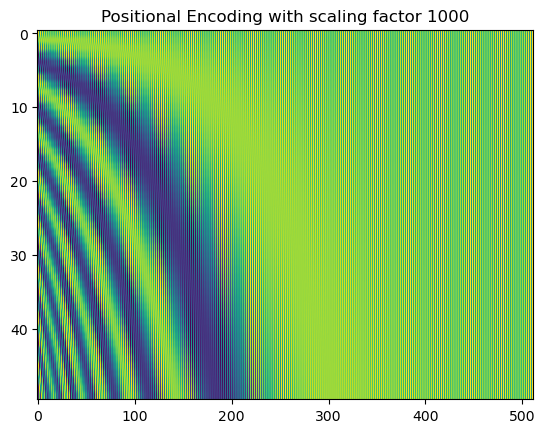

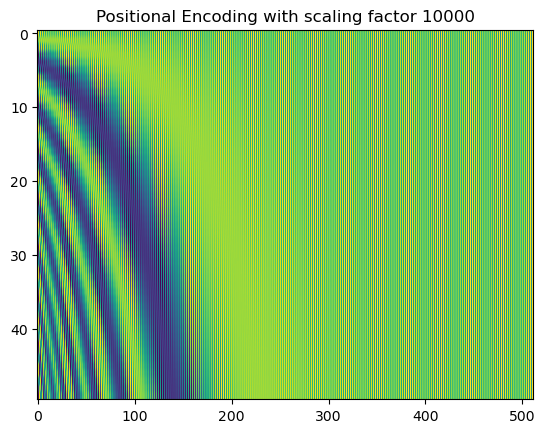

In [3]:
from matplotlib.pyplot import figure, show

for scaling_factor in [1, 10, 100, 1000, 10000]:
    positional_encoding = PositionalEncoding(50, 512, scaling_factor)
    embeddings = positional_encoding.embeddings.detach().numpy()

    plot = figure()
    ax = plot.add_subplot()
    ax.imshow(embeddings, cmap='viridis', aspect='auto')
    ax.set_title(f"Positional Encoding with scaling factor {scaling_factor}")
    show()

### Self-Attention

Given three tensors $Q, K, V \in \mathbb{R}^{l \times d_k}$, $\mathbb{R}^{l \times d_k}$ and $\mathbb{R}^{l \times d_v}$ respectively, the attention is calculated as:

$$ \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

In [4]:
import math
from typing import Optional
from torch import Tensor
from torch.nn.functional import softmax

def attention(query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tensor:        
    scale = 1 / math.sqrt(key.size(-1))
    score = query @ key.transpose(-2, -1) * scale
    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf'))
    return softmax(score, dim=-1) @ value

In [5]:
import torch
from torch.nn.functional import scaled_dot_product_attention

query = torch.randn(8, 4, 512)
key = torch.randn(8, 4, 512)
value = torch.randn(8, 4, 512)

assert torch.allclose(attention(query, key, value), scaled_dot_product_attention(query, key, value), atol=1e-5)

### Multihead attention

In the transformers model, the attention mechanism is applied in parallel to multiple projections of the queries, keys and values. Each projection is called an "attention head". To define these projections, three weight matrices $W^Q$, $W^K$ and $W^V$ are used that are applied to the queries, keys and values respectively.

Let:

- $W^Q \in \mathbb{R}^{d \times d_q}$
- $W^K \in \mathbb{R}^{d \times d_k}$
- $W^V \in \mathbb{R}^{d \times d_v}$


With $d_q = d_k$. Given a tensor $X \in \mathbb{R}^{l \times d}$, we say that the products:

- $X W^Q \in \mathbb{R}^{l \times d_k} $
- $X W^K  \in \mathbb{R}^{l \times d_k} $
- $X W^VX  \in \mathbb{R}^{l \times d_v}  $ 

Are the projections of the tensor $X$ in the query, key and value spaces respectively. We can then define the multi-head attention mechanism as:

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \cdots, \text{head}_h) W^O $$
$$ \text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i) $$


With $Q W^Q_i$, $K W^K_i$ and $V W^V_i$ the projections of the tensors $Q$, $K$ and $V$ in the query, key and value spaces respectively, for a head $\text{head}_i$, and $W^O$ is another transformation that is applied to the result of concatenating the outputs of each head. These transformations are responsible for generating the different "heads" from the queries, keys and original values.

Although in the definition of the multi-head attention mechanism layer, different views are generated for the input tensors $Q$, $K$ and $V$, in practice, it is simpler and computationally more efficient to generate a single projection of these tensors and then divide them into $h$ parts, so that the matrices $Q_i$, $K_i$ and $V_i$ are generated for each head $i$. This can be achieved as follows:

Given a projection $P \in \mathbb{R}^{l \times d}$, either $P = W^Q Q, W^K K$ or $W^V V$ we can divide each row of $P$ into $h$ parts of dimension $d/h$ and then group the vectors of each part into a matrix of dimension $l \times d/h$ in the same tensor by adding a dimension as follows:


$$ P = \begin{bmatrix} 

    p^1_1 & p^1_2 & \cdots & p^1_d  \\
    p^2_1 & p^2_2 & \cdots & p^2_d   \\
    \vdots & \vdots & \ddots  & \vdots \\
    p^l_1 & p^l_2 & \cdots & p^l_d  \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^1_{d\frac{(h-1)}{h}+1} &  \cdots & p^1_d  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^l_1 & \cdots & p^l_{d/h}  \\

        
    \vdots & \ddots  & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & p^1_2 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^l_1 & p^l_2 & \cdots & p^l_{d/h}  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^1_{d\frac{(h-1)}{h}+1}  & \cdots & p^1_d  \\

        
    \vdots & \vdots & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} 

$$ 

Where the first matrix is the first head, the second matrix is the second head and so on. The final result is a tensor of dimension $h \times l \times d/h$.

The concatenation of the outputs of each head is done in the dimension $d/h$ and is the inverse process to the one described for the "split" so that the final result is a tensor of dimension $l \times d_v$.

Finally, the output is multiplied by the matrix $W^O \in \mathbb{R}^{d_v \times d}$ to obtain the final result of the multi-head attention layer, which will have dimension $l \times d$.

In [6]:
from typing import Optional
from torch import Tensor
from torch.nn import Module
from torch.nn import Linear
from torch.nn import init

def split(sequence: Tensor, number_of_heads: int) -> Tensor:
    batch_size, sequence_length, model_dimension = sequence.size()
    sequence = sequence.view(batch_size, sequence_length, model_dimension // number_of_heads, number_of_heads)
    sequence = sequence.transpose(1, 2)
    return sequence

def concat(sequence: Tensor) -> Tensor:
    batch_size, heads_dimension, sequence_lenght, number_of_heads = sequence.size()
    sequence = sequence.transpose(1, 2).contiguous()
    sequence = sequence.view(batch_size, sequence_lenght, heads_dimension* number_of_heads)
    return sequence

class MultiheadAttention(Module):
    def __init__(self, model_dimension: int, key_dimension: int, value_dimension: int, number_of_heads):
        super().__init__()
        self.number_of_heads = number_of_heads
        self.query_projector_weight = Parameter(torch.empty(model_dimension, model_dimension))
        self.key_projector_weight = Parameter(torch.empty(model_dimension, key_dimension))
        self.value_projector_weight = Parameter(torch.empty(model_dimension, value_dimension))
        self.output_projector_weight = Parameter(torch.empty(model_dimension, model_dimension))

        init.xavier_normal_(self.query_projector_weight)
        init.xavier_normal_(self.key_projector_weight)
        init.xavier_normal_(self.value_projector_weight)
        init.xavier_normal_(self.output_projector_weight)


    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tensor:
        query, key, value = query @ self.query_projector_weight.T, key @ self.key_projector_weight.T, value @ self.value_projector_weight.T
        query, key, value = split(query, self.number_of_heads), split(key, self.number_of_heads), split(value, self.number_of_heads)
        heads = attention(query, key, value, mask)
        heads = concat(heads)
        return heads @ self.output_projector_weight.T

In [7]:
import torch
from torch.nn import Parameter
from torch.nn import MultiheadAttention as PytorchMultiheadAttention

query = torch.ones(8, 32, 512)
key = torch.ones(8, 32, 256)
value = torch.ones(8, 32, 256)

multihead = MultiheadAttention(512, 256, 256, 8)
pytorch_multihead = PytorchMultiheadAttention(512, 8, kdim=256, vdim=256, bias=False)
pytorch_multihead.q_proj_weight = Parameter(multihead.query_projector_weight.detach().clone())
pytorch_multihead.k_proj_weight = Parameter(multihead.key_projector_weight.detach().clone())
pytorch_multihead.v_proj_weight = Parameter(multihead.value_projector_weight.detach().clone())
pytorch_multihead.out_proj.weight = Parameter(multihead.output_projector_weight.detach().clone())

assert torch.allclose(multihead(query, key, value), pytorch_multihead(query, key, value)[0], atol=1e-5)

query = torch.ones(8, 32, 512)
key = torch.ones(8, 32, 512)
value = torch.ones(8, 32, 512)

multihead = MultiheadAttention(512, 512, 512, 8)
pytorch_multihead = PytorchMultiheadAttention(512, 8)
with torch.no_grad():
    pytorch_multihead.in_proj_weight[:512,:].copy_(multihead.query_projector_weight.detach().clone())
    pytorch_multihead.in_proj_weight[512:512+512,:].copy_(multihead.key_projector_weight.detach().clone())
    pytorch_multihead.in_proj_weight[512+512:512+512+512,:].copy_(multihead.value_projector_weight.detach().clone())
    pytorch_multihead.out_proj.weight = Parameter(multihead.output_projector_weight.detach().clone())

assert torch.allclose(multihead(query, key, value), pytorch_multihead(query, key, value)[0], atol=1e-5)

### Layer normalization

Then the normalization by layer or "layer normalization" is defined, which is described in the paper https://arxiv.org/pdf/1607.06450, which consists of normalizing the values of a tensor $X \in \mathbb{R}^{l \times d}$ along the dimension $d$ for each vector of the sequence, as follows:

$$ \text{LayerNorm}(X) = \gamma \frac{X - \mu}{\sqrt{\text{Var}(X) + \epsilon}} + \beta $$

Where $\mu$ and $\text{Var}(X)$ are the mean and variance of the values of $X$ along the dimension $d$ respectively, and $\gamma$ and $\beta$ are parameters that are learned during training.

In [8]:
from torch import zeros, ones
from torch import rsqrt
from torch import Tensor
from torch.nn import Parameter
from torch.nn import Module

class LayerNormalization(Module):
    def __init__(self, model_dimension: int, epsilon: float = 0.00001, bias: bool = True):
        super().__init__()
        self.gamma = Parameter(data=ones(model_dimension))
        self.beta = Parameter(data=zeros(model_dimension)) if bias else None
        self.epsilon = epsilon

    def forward(self, input: Tensor) -> Tensor:
        mean = input.mean(dim=-1, keepdim=True)
        variance = input.var(dim=-1, unbiased=True, keepdim=True)
        output = self.gamma * ((input - mean) *rsqrt(variance + self.epsilon)) 
        return output + self.beta if self.beta else output

In [9]:
from torch import Tensor
from torch.nn import Parameter
from torch.nn import LayerNorm as PytorchLayerNorm

layer_norm = LayerNormalization(512)
pytorch_layer_norm = PytorchLayerNorm(512)

pytorch_layer_norm.weight = Parameter(layer_norm.gamma.detach().clone())
pytorch_layer_norm.bias = Parameter(layer_norm.beta.detach().clone())

input = torch.randn(8, 32, 512)


print(layer_norm(input))
print(pytorch_layer_norm(input))

#TODO: The values are not close enough, need to investigate.
assert torch.allclose(layer_norm(input), pytorch_layer_norm(input), atol=1e-2)

tensor([[[ 0.3422, -1.2783, -0.5121,  ...,  0.5404, -1.5226,  0.8263],
         [ 0.2922,  1.2283,  0.7363,  ...,  0.4466, -2.1733, -1.8395],
         [ 0.0700, -2.0283,  0.4989,  ...,  0.7141,  0.7067, -1.3311],
         ...,
         [ 0.4898, -0.5737,  0.2818,  ..., -0.1014,  0.4988, -0.4145],
         [ 0.2527, -1.2005, -0.1269,  ...,  0.3796, -0.2263,  0.5354],
         [ 0.4823,  0.0878,  3.1529,  ..., -0.0081,  0.2283,  0.1158]],

        [[-0.7847,  1.8135,  0.4577,  ..., -1.5703,  3.5931, -0.1465],
         [ 0.1617,  1.8756,  1.3484,  ...,  0.3619, -1.1070,  0.2892],
         [ 1.5856,  0.8529, -0.0781,  ...,  0.1011, -0.1707, -1.6843],
         ...,
         [-0.1868,  1.3700,  0.3338,  ..., -0.8438, -0.9588, -0.7933],
         [ 1.8170,  0.1848, -1.5049,  ...,  0.2645, -2.4748,  0.1180],
         [-0.7380, -0.5724, -0.0662,  ..., -0.6312, -1.3547, -0.3291]],

        [[-0.0248, -0.2143,  1.2463,  ...,  1.8942,  0.8927,  0.1949],
         [-0.9072, -0.2799,  0.3770,  ..., -1

Finally a feedforward layer is applied to the output of the multi-head attention layer.

In [10]:
from torch import Tensor
from torch.nn import Module, Linear, ReLU, Sequential, Dropout

class FeedForward(Module):
    def __init__(self, model_dimension: int, hidden_dimension: int, dropout_rate: float = 0.2, bias: bool = False):
        super().__init__()
        self.layers = Sequential(
            Linear(model_dimension, hidden_dimension, bias),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dimension, model_dimension, bias)
        )
    
    def forward(self, input: Tensor) -> Tensor:
        return self.layers(input)

### Architecture 


![transformer](https://upload.wikimedia.org/wikipedia/commons/8/8f/The-Transformer-model-architecture.png)

In [11]:
from torch import Tensor
from torch.nn import Module

class Encoder(Module):
    def __init__(self, model_dimension: int, ffn_dimension: int, number_of_heads: int, dropout: float = 0.2, bias: bool = False):
        super().__init__()
        self.multihead_attention = MultiheadAttention(model_dimension, model_dimension, model_dimension, number_of_heads)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.feed_forward_network = FeedForward(model_dimension, ffn_dimension, dropout, bias)
        self.second_layer_normalization = LayerNormalization(model_dimension)

    def forward(self, sequence: Tensor, mask: Optional[Tensor] = None) -> Tensor:
        sequence = sequence + self.multihead_attention(sequence, sequence, sequence, mask)
        sequence = self.first_layer_normalization(sequence)        
        sequence = sequence + self.feed_forward_network(sequence)
        sequence = self.second_layer_normalization(sequence)
        return sequence

In [15]:
from torch.nn import TransformerDecoderLayer as PytorchDecoderLayer
from torch.nn import TransformerEncoderLayer as PytorchEncoderLayer

encoder = Encoder(512, 2048, 8, dropout=0, bias=False)
pytorch_encoder = PytorchEncoderLayer(512, 8, 2048, dropout=0, bias=False)

with torch.no_grad():
    pytorch_encoder.self_attn.in_proj_weight[:512,:].copy_(encoder.multihead_attention.query_projector_weight.detach().clone())
    pytorch_encoder.self_attn.in_proj_weight[512:512+512,:].copy_(encoder.multihead_attention.key_projector_weight.detach().clone())
    pytorch_encoder.self_attn.in_proj_weight[512+512:512+512+512,:].copy_(encoder.multihead_attention.value_projector_weight.detach().clone())
    pytorch_encoder.self_attn.out_proj.weight = Parameter(encoder.multihead_attention.output_projector_weight.detach().clone())

    pytorch_encoder.linear1.weight = Parameter(encoder.feed_forward_network.layers[0].weight.detach().clone())
    pytorch_encoder.linear2.weight = Parameter(encoder.feed_forward_network.layers[3].weight.detach().clone())

    pytorch_encoder.norm1.weight = Parameter(encoder.first_layer_normalization.gamma.detach().clone())
    pytorch_encoder.norm2.weight = Parameter(encoder.second_layer_normalization.gamma.detach().clone())

sequence = torch.randn(8, 32, 512)

print(encoder(sequence))
print(pytorch_encoder(sequence))

tensor([[[-0.6265,  0.0404, -0.0737,  ..., -0.4042, -0.2501,  1.6793],
         [-0.4432,  1.1320,  0.4952,  ...,  0.2120, -0.5349,  1.5573],
         [ 0.0880,  1.4859,  0.4371,  ...,  0.2951, -0.9217,  0.9267],
         ...,
         [ 1.5186,  0.5133, -1.1346,  ...,  0.2450, -0.3207,  0.2545],
         [-0.8709, -0.2426, -0.5271,  ...,  1.9766, -0.2229, -1.2168],
         [ 0.5169, -1.0172,  0.1781,  ...,  1.9963, -0.0266,  2.2893]],

        [[-0.4894, -0.4660, -0.6851,  ..., -0.1059, -0.6207, -0.7945],
         [ 0.8661, -1.2624, -1.7828,  ...,  0.2449,  0.9276, -0.2085],
         [ 0.4208, -1.7887,  0.5912,  ..., -0.0573,  0.7636, -1.5367],
         ...,
         [-0.0785, -0.0415, -0.1545,  ...,  1.0785,  0.4892,  0.1825],
         [ 0.5900, -0.4776,  0.9255,  ...,  0.6428,  1.1916,  0.3427],
         [ 1.0588, -0.8266, -0.5885,  ...,  0.1647,  0.2010, -0.3256]],

        [[ 0.4926, -0.5879,  0.9334,  ...,  1.2009, -1.4588,  0.0624],
         [ 0.0348, -0.1828,  1.0936,  ..., -1

In [13]:
class Decoder(Module):
    def __init__(self, model_dimension: int, ffn_dimension: int, number_of_heads: int, dropout: float = 0.2):
        super().__init__()
        self.first_multihead_attention = MultiheadAttention(model_dimension, model_dimension, model_dimension, number_of_heads)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.second_multihead_attention = MultiheadAttention(model_dimension, model_dimension, model_dimension, number_of_heads)
        self.second_layer_normalization = LayerNormalization(model_dimension)
        
        self.feed_forward_network = FeedForward(model_dimension, ffn_dimension, dropout)
        self.third_layer_normalization = LayerNormalization(model_dimension)
        
    def forward(self, input: Tensor, output: Tensor, input_mask: Optional[Tensor] = None, output_mask: Optional[Tensor] = None) -> Tensor:
        output = output + self.first_multihead_attention(output, output, output, output_mask)
        output = self.first_layer_normalization(output)

        output = output + self.second_multihead_attention(input, input, output, input_mask)
        output = self.second_layer_normalization(output)

        output = output + self.feed_forward_network(output)
        output = self.third_layer_normalization(output)
        return output

In [14]:
from dataclasses import dataclass
from torch import Tensor
from torch.nn import Embedding
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import Softmax

@dataclass
class Configuration:
    vocabulary_size: int
    model_dimension: int
    feed_forward_hidden_dimension: int
    number_of_heads: int
    key_dimension: int
    value_dimension: int
    encoder_layers: int
    decoder_layers: int

class Transformer(Module):
    def __init__(self, configuration: Configuration):
        super().__init__()
        self.embedding = Embedding(configuration.vocabulary_size, configuration.model_dimension)
        self.positional_encoding = PositionalEncoding(512, configuration.model_dimension)
        self.encoder = ModuleList([Encoder(
            configuration.model_dimension, 
            configuration.feed_forward_hidden_dimension, 
            configuration.number_of_heads, 
            configuration.key_dimension, 
            configuration.value_dimension
        ) for layer in range(configuration.encoder_layers)])

        self.decoder = ModuleList([Decoder(
            configuration.model_dimension, 
            configuration.feed_forward_hidden_dimension, 
            configuration.number_of_heads, 
            configuration.key_dimension, 
            configuration.value_dimension
        ) for layer in range(configuration.decoder_layers)])

        self.linear = Linear(configuration.model_dimension, configuration.vocabulary_size)
        self.softmax = Softmax(dim=-1)

        self.input_mask = None
        self.output_mask = None

    def forward(self, input: Tensor, output: Tensor) -> Tensor:
        input, output = self.embedding(input), self.embedding(output)
        input, output = self.positional_encoding(input), self.positional_encoding(output)

        for layer in self.encoder:
            input = layer(output, self.input_mask)

        for layer in self.decoder:
            output = layer(input, output, self.input_mask, self.output_mask)

        output = self.linear(output)
        output = self.softmax(output)
        return output